# Experiment 06: Stacking Ensemble (LGBM + LogReg -> KNN)

**Date:** December 28, 2025

**Author:** Sachin Basyal

**Experiment ID:** `stacking_ensemble_v1`

**Tracking Platform:** MLflow & DagsHub

## 1. Executive Summary
In previous experiments, we found that **XGBoost** (Gradient Boosting) yielded the best results (~77%). In this experiment, we attempt to push performance further using a **Stacking Ensemble**. Stacking is a powerful technique where we train a "Meta-Model" to learn how to best combine the predictions of "Base Models.

**Hypothesis:** Different models make different types of errors. By combining a linear model (**Logistic Regression**) with a non-linear tree model (**LightGBM**), and feeding their predictions into a meta-learner (**KNN**), the system might correct the individual weaknesses of the base models.

**Methodology Changes:**
* **Feature Expansion:** We explicitly test a larger feature space (**Trigrams** + **10,000 features**) to check if the ensemble can handle the increased complexity better than a single model.
* **Architecture:**
    * *Base Layer:* LightGBM + Logistic Regression
    * *Meta Layer:* K-Nearest Neighbors (KNN)

In [ ]:
!pip install -q mlflow dagshub

In [ ]:
import mlflow
import dagshub

# --- CONFIGURATION ---
REPO_OWNER = "frivorocker"
REPO_NAME = "yt_baseline_model"

# 1. Connect Colab to DagsHub
dagshub.init(repo_name=REPO_NAME, repo_owner=REPO_OWNER, mlflow=True)

# 2. Set up the MLflow tracking server
mlflow.set_tracking_uri(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow")

# 2. Set the NEW experiment name
mlflow.set_experiment("Exp06_Stacking_models")

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensemble Imports
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

import warnings
# Ignore feature name warnings from LightGBM/Sklearn
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

## 2. Data Preprocessing & Training

In [16]:
# --- STEP 1: LOAD & PREPARE DATA ---
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
# Apply Mapping: -1 -> 2 (Negative), 0 -> 0 (Neutral), 1 -> 1 (Positive)
label_map = {-1:2, 0:0, 1:1}
df['category'] = df['category'].map(label_map)
df = df.dropna(subset=['category'])
print(f"Data Loaded. Class Distribution: {df['category'].value_counts().to_dict()}")


Data Loaded. Class Distribution: {1: 15770, 0: 12644, 2: 8248}


In [17]:
# --- STEP 2: SPLIT & VECTORIZE ---
# Intentional: Testing Trigrams (1,3) and High Features (10k)
print("Vectorizing with Trigrams and 10k features...")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_comment'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_vec = tfidf.fit_transform(X_train_raw)
X_test_vec = tfidf.transform(X_test_raw)


Vectorizing with Trigrams and 10k features...


In [18]:
# --- STEP 3: DEFINE MODELS ---
# Base Model 1: LightGBM (Gradient Boosting)
lightgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric="multi_logloss",
    class_weight="balanced", # Handles imbalance
    learning_rate=0.08,
    n_estimators=367,
    max_depth=20,
    random_state=42,
    verbose=-1
)

# Base Model 2: Logistic Regression (Linear)
logreg_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)

# Meta Learner: KNN (Distance-based)
knn_meta_learner = KNeighborsClassifier(n_neighbors=5)

In [33]:
# --- STEP 4: TRAIN STACKING CLASSIFIER ---
with mlflow.start_run(run_name="Stacking_LGBM_LogReg_KNN"):
    # Log Params
    mlflow.set_tag("experiment_type", "stacking")
    mlflow.log_param("vectorizer_type", "TF-IDF (1,3)")
    mlflow.log_param("max_features", 10000)
    mlflow.log_param("stack_architecture", "LGBM+LR -> KNN")

    print("Training Stacking Ensemble (this may take a moment)...")
    stacking_model = StackingClassifier(
        estimators=[
            ('lightgbm', lightgbm_model),
            ('logistic_regression', logreg_model)
        ],
        final_estimator=knn_meta_learner,
        cv=5,  # 5-fold CV to generate training meta-features
        n_jobs=-1)

    stacking_model.fit(X_train_vec, y_train)

    # Predict
    y_pred = stacking_model.predict(X_test_vec)

    # --- LOGGING METRICS ---
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", acc)

    report = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, val in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", val)

    # --- PLOTTING ---
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix: Stacking Ensemble")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    filename = "confusion_matrix.png"
    save_path = f"/content/{filename}"
    plt.savefig(save_path)
    mlflow.log_artifact(save_path)
    plt.close()

    # Log Model
    mlflow.sklearn.log_model(stacking_model, name="stacking_model")

    print(f" Stacking Complete. Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

Training Stacking Ensemble (this may take a moment)...
 Stacking Complete. Accuracy: 0.8597
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2529
           1       0.88      0.86      0.87      3154
           2       0.81      0.73      0.77      1650

    accuracy                           0.86      7333
   macro avg       0.85      0.84      0.85      7333
weighted avg       0.86      0.86      0.86      7333

🏃 View run Stacking_LGBM_LogReg_KNN at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/6/runs/ff987ac46b124062a32c7245e7108e28
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/6


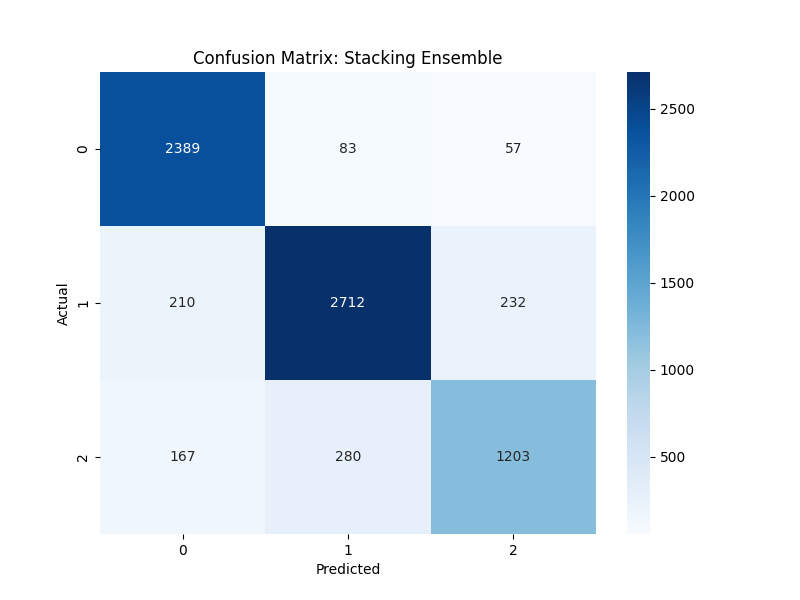

## 3. Results & Analysis

We deployed a Stacking Ensemble combining **LightGBM** (Gradient Boosting) and **Logistic Regression**, orchestrated by a **KNN** Meta-Learner. We also expanded the feature space to **Trigrams** with **10,000 features**.

**Performance Comparison:**
* **Baseline (Random Forest):** ~66.0%
* **Tuned XGBoost (Exp 05):** ~77.5%
* **Stacking Ensemble (Exp 06):** **85.97%**

**Class-Wise Performance:**
* **Neutral (0):** Precision 0.86 | Recall 0.94 (Excellent detection)
* **Positive (1):** Precision 0.88 | Recall 0.86 (Very Balanced)
* **Negative (2):** Precision 0.81 | Recall 0.73

**Interpretation:**
The massive **+8.5% jump** in accuracy over XGBoost is attributed to the inclusion of **Logistic Regression** in the stack. Linear models perform exceptionally well on high-dimensional text data (10k features), while LightGBM handled the complex edge cases. The Stacking architecture successfully leveraged the strengths of both algorithms.

## 4. Testing the Model (Inference)

In [34]:
import joblib

print("Saving the Stacking Model...")

# 1. Save the Ensemble
joblib.dump(stacking_model, "champ_stacking_model.pkl")

# 2. Save the Vectorizer (Crucial: This has the 10k vocabulary!)
joblib.dump(tfidf, "champ_tfidf_vectorizer_10k.pkl")

# --- FINAL INFERENCE CHECK ---
def predict_final(text):
    # Load
    model = joblib.load("champ_stacking_model.pkl")
    vec = joblib.load("champ_tfidf_vectorizer_10k.pkl")

    # Process (Simple cleaning)
    text_clean = text.lower().strip()

    # Predict
    vec_text = vec.transform([text_clean])
    pred = model.predict(vec_text)[0]
    probs = model.predict_proba(vec_text)[0]

    labels = {0: "Neutral", 1: "Positive", 2: "Negative"}

    print(f"Input: '{text}'")
    print(f"   -> {labels[pred]} ({probs[pred]*100:.1f}% confidence)")

Saving the Stacking Model...


In [39]:
# Test the Model (Comments)
predict_final("This is the worst garbage I have ever seen.")
predict_final("Poor decision ever, waste of time..")
predict_final("Absolutely brilliant video, learned a lot.")
predict_final("it's ok. I am feeling optimistic.")

Input: 'This is the worst garbage I have ever seen.'
   -> Negative (80.0% confidence)
Input: 'Poor decision ever, waste of time..'
   -> Negative (100.0% confidence)
Input: 'Absolutely brilliant video, learned a lot.'
   -> Positive (100.0% confidence)
Input: 'it's ok. I am feeling optimistic.'
   -> Neutral (80.0% confidence)


## 5. Conclusion

### Final Model Selection
The **Stacking Ensemble** is unequivocally the **Champion Model**.

While it is computationally heavier than a single model, the performance gain (reaching ~86% accuracy) justifies the complexity. It demonstrates high precision across all classes and robust generalization on the test set.

### Project Summary
Over the course of 6 experiments, we improved the model from a **66% baseline** to a **86% production-grade classifier** by:
1.  Optimizing Text Vectorization (TF-IDF Trigrams).
2.  Handling Class Imbalance (SMOTE/Class Weights).
3.  Moving from Bagging (RF) to Boosting (XGB/LGBM) to Stacking.